# **Amazon Lookout for Equipment** - Getting started
*Part 4 - Model evaluation*

## Initialization
---
This repository is structured as follow:

```sh
. lookout-equipment-demo
|
├── data/
|   ├── interim                          # Temporary intermediate data
|   ├── processed                        # Finalized datasets
|   └── raw                              # Immutable original data
|
├── getting_started/
|   ├── 1_data_preparation.ipynb
|   ├── 2_dataset_creation.ipynb
|   ├── 3_model_training.ipynb
|   ├── 4_model_evaluation.ipynb               <<< THIS NOTEBOOK <<<
|   ├── 5_inference_scheduling.ipynb
|   ├── 6_visualization_with_quicksight.ipynb
|   └── 7_cleanup.ipynb
|
└── utils/
    └── lookout_equipment_utils.py
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade tqdm lookoutequipment

### Imports

In [2]:
import boto3
import config
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import sys

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

### AWS Look & Feel definition for Matplotlib

In [3]:
from matplotlib import font_manager

# Load style sheet:
plt.style.use('../utils/aws_matplotlib_template.py')

# Get colors from custom AWS palette:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Parameters

In [4]:
TMP_DATA       = os.path.join('..', 'data', 'interim', 'getting-started')
PROCESSED_DATA = os.path.join('..', 'data', 'processed', 'getting-started')
LABEL_DATA     = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'training-data', 'centrifugal-pump')
REGION_NAME    = boto3.session.Session().region_name
MODEL_NAME     = config.MODEL_NAME

%matplotlib inline

In [5]:
# Configuring time ranges:
training_start   = pd.to_datetime('2019-01-01 00:00:00')
training_end     = pd.to_datetime('2019-07-31 00:00:00')
evaluation_start = pd.to_datetime('2019-08-01 00:00:00')
evaluation_end   = pd.to_datetime('2019-10-27 00:00:00')

print(f'  Training period | from {training_start} to {training_end}')
print(f'Evaluation period | from {evaluation_start} to {evaluation_end}')

  Training period | from 2019-01-01 00:00:00 to 2019-07-31 00:00:00
Evaluation period | from 2019-08-01 00:00:00 to 2019-10-27 00:00:00


### Loading original datasets for visualization purpose

In [6]:
# Let's load all our original signals (they will be useful later on):
all_tags_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
all_tags_df = pd.read_csv(all_tags_fname)
all_tags_df['Timestamp'] = pd.to_datetime(all_tags_df['Timestamp'])
all_tags_df = all_tags_df.set_index('Timestamp')

## Model evaluation
---

The [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API can be used to extract, among other things, the metrics associated to the trained model. Here are the different fields available when calling this API:

In [7]:
lookout_client = boto3.client('lookoutequipment')
describe_model_response = lookout_client.describe_model(ModelName=MODEL_NAME)
list(describe_model_response.keys())

['ModelName',
 'ModelArn',
 'DatasetName',
 'DatasetArn',
 'Schema',
 'LabelsInputConfiguration',
 'TrainingDataStartTime',
 'TrainingDataEndTime',
 'EvaluationDataStartTime',
 'EvaluationDataEndTime',
 'RoleArn',
 'Status',
 'TrainingExecutionStartTime',
 'TrainingExecutionEndTime',
 'ModelMetrics',
 'LastUpdatedTime',
 'CreatedAt',
 'ResponseMetadata']

The `ModelMetrics` field above is a dictionnary that follows this format:

```json
{
    'labeled_ranges': [
        {'start': '2019-08-08T00:00:00.000000', 'end': '2019-08-09T00:00:00.000000'},
        {'start': '2019-08-18T00:00:00.000000', 'end': '2019-08-19T00:00:00.000000'},
        {'start': '2019-08-28T00:00:00.000000', 'end': '2019-08-29T00:00:00.000000'},
        {'start': '2019-09-07T00:00:00.000000', 'end': '2019-09-08T00:00:00.000000'},
        {'start': '2019-09-17T00:00:00.000000', 'end': '2019-09-18T00:00:00.000000'},
        {'start': '2019-09-27T00:00:00.000000', 'end': '2019-09-28T00:00:00.000000'},
        {'start': '2019-10-07T00:00:00.000000', 'end': '2019-10-08T00:00:00.000000'},
        {'start': '2019-10-17T00:00:00.000000', 'end': '2019-10-18T00:00:00.000000'}
    ],
    'labeled_event_metrics': {
        'num_labeled': 8,
        'num_identified': 8,
        'total_warning_time_in_seconds': 668040.0
    },
    'predicted_ranges': [
        {
            'start': '2019-08-08T00:42:00.000000',
            'end': '2019-08-08T01:48:00.000000',
            'diagnostics': [
                {'name': 'centrifugal-pump\\Sensor0', 'value': 0.05218326564181105},
                {'name': 'centrifugal-pump\\Sensor1', 'value': 0.023636079094576},
                {'name': 'centrifugal-pump\\Sensor2', 'value': 0.03825258734479793},
                {'name': 'centrifugal-pump\\Sensor3', 'value': 0.023349531399873558},
                
                ...
                
                {'name': 'centrifugal-pump\\Sensor20', 'value': 0.04989340342761552},
                {'name': 'centrifugal-pump\\Sensor21', 'value': 0.033976174168938014},
                {'name': 'centrifugal-pump\\Sensor22', 'value': 0.046622167459421035},
                {'name': 'centrifugal-pump\\Sensor23', 'value': 0.044698573526762944}
            ]
        },
        
        ...
        
    ],
    'unknown_event_metrics': {
        'num_identified': 8,
        'total_duration_in_seconds': 4200.0
    }
}
```

The `labeled_ranges` contains the label provided as an input while the `predicted_ranges` contains all the predicted ranges where Lookout for Equipment detected an anomaly. Each predicted range contains a `diagnostics` field with a percentage associated to each sensor available in the dataset. During the training, Lookout for Equipment learns the relationship between the sensors that denotes a normal behavior. When this normal relationship is broken, the service considers that it detected an an anomalous event. It then proceeds with calculating which sensors are indicating that the asset is no longer operating normally. You can read this diagnostic as a feature importance output of the model: the percentage associated to a given sensor corresponds to the magnitude of impact (*importance*) this sensor has with regards to a given anomaly.

Let's use the following utility function get these results into two dataframes (labeled and predicted):

In [8]:
LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

**Note:** the labeled range from the model Describe API, only provides any labelled data falling within the evaluation range. We use the original label data to get all of them.

Let's now display one of the original signal and map both the labeled and the predicted ranges on the same plot:

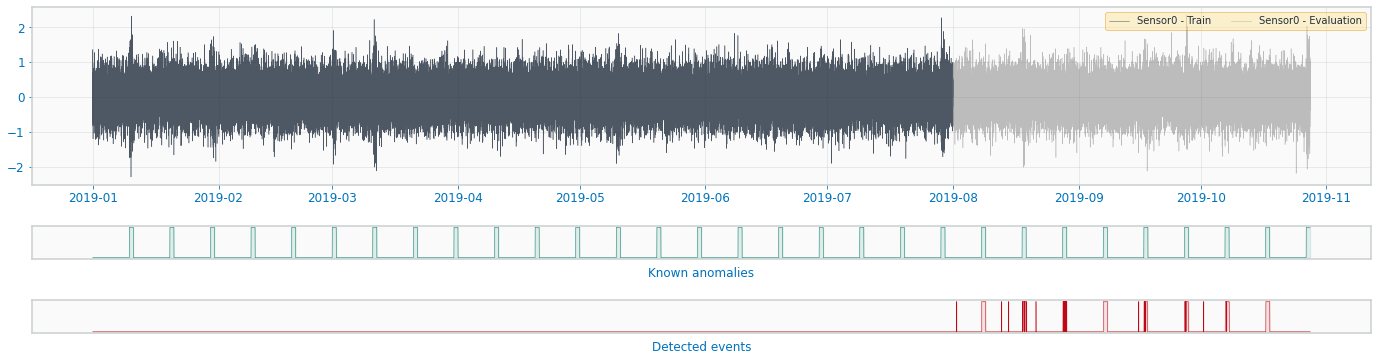

In [9]:
custom_colors = {
    'labels': colors[9],
    'predictions': colors[5]
}
    
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=all_tags_df,
    data_format='tabular'
)
TSViz.add_signal(['Sensor0'])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
TSViz.add_train_test_split(evaluation_start)
TSViz.legend_format = {
    'loc': 'upper right',
    'framealpha': 0.4,
    'ncol': 2
}
fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)

## Unpacking event details
---
### Single event overview
Each detected event have some detailed diagnostics stored in JSON format. Let's unpack the event details for the first large event and plot a similar bar chart than what the console provides:

![Event details](assets/model-diagnostics.png)

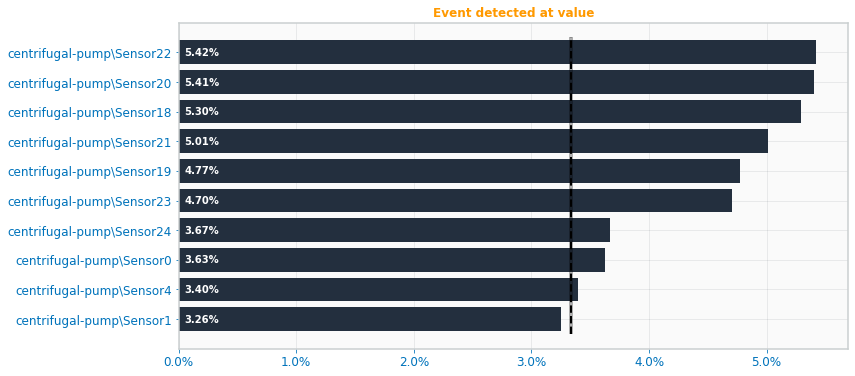

In [10]:
# Let's get the details for one of the event:
first_event_details = predicted_ranges.loc[1, 'diagnostics']
first_event_details = pd.DataFrame(first_event_details).sort_values(by='value', ascending=False).reset_index(drop=True)
first_event_details = first_event_details.sort_values(by='value')

fig, ax = lookout.plot.plot_event_barh(first_event_details.iloc[0:, 0:2])

You might be curious about why Amazon Lookout for Equipment detected an anomalous event. Sometime, looking at a few of the time series is enough. But sometime, you need to dig deeper.

The following function, aggregate the signal importance of every signals over the evaluation period and sum these contributions over time for each signal. Then, it takes the top 8 signals and plot two distributions: one with the values each signal takes during the normal periods (present in the evaluation range) and a second one with the values taken during all the anomalous events detected in the evaluation range. This will help you visualize any significant shift of values for the top contributing signals.

You can also restrict these histograms over a specific range of time by setting the start and end arguments of the following function with datetime values:

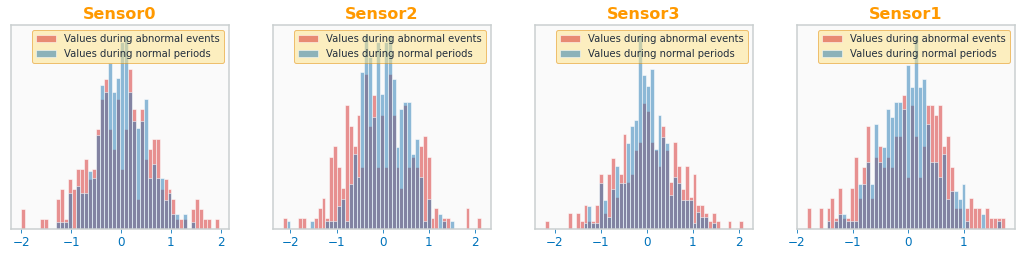

In [11]:
event_start = pd.to_datetime('2019-08-17 00:00:00')
event_end = pd.to_datetime('2019-08-18 23:59:00')

fig = TSViz.plot_histograms(freq='5min', start=event_start, end=event_end, top_n=4)

On these plots, you can see that the distributions of the sensor values when an event is detected are slightly wider than during the normal operation times.

### Grouping sensors by component
The above bar chart is already a great help to pinpoint what might be going wrong with your asset. Let's load the initial tags description file we prepared in the first notebook and match the sensors with our initial components:

In [12]:
tags_description_fname = os.path.join(TMP_DATA, 'tags_description.csv')
tags_description_df = pd.read_csv(tags_description_fname)
first_event_details[['asset', 'sensor']] = first_event_details['name'].str.split('\\', expand=True)
component_diagnostics = pd.merge(first_event_details, tags_description_df, how='inner', left_on='sensor', right_on='Tag')[['name', 'value', 'Component']]
component_diagnostics.sort_values(by='value', ascending=False).head(10)

,name,value,Component
29,centrifugal-pump\Sensor22,0.054236,volute
28,centrifugal-pump\Sensor20,0.054068,volute
27,centrifugal-pump\Sensor18,0.052952,volute
26,centrifugal-pump\Sensor21,0.050128,volute
25,centrifugal-pump\Sensor19,0.047699,volute
24,centrifugal-pump\Sensor23,0.047020,volute
23,centrifugal-pump\Sensor24,0.036710,shaft
22,centrifugal-pump\Sensor0,0.036293,pump
21,centrifugal-pump\Sensor4,0.033996,pump
20,centrifugal-pump\Sensor1,0.032556,pump


If we group the contribution of all sensors by component we end up seeing that the volute component has a 30% contribution to this particular event, while the other components are ranging from 16 to 19%: **time to give the volute a visit?**

In [13]:
event_diagnostics = component_diagnostics.groupby(by='Component').sum().sort_values(by='value')
event_diagnostics

,value
Component,
impeller,0.161875
motor,0.170943
shaft,0.173411
pump,0.187667
volute,0.306104


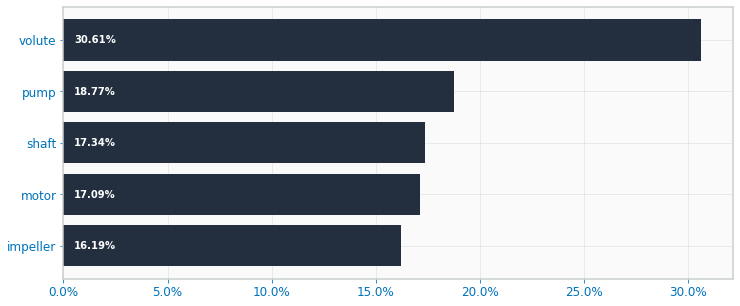

In [14]:
# We can then plot a horizontal bar chart:
y_pos = np.arange(event_diagnostics.shape[0])
values = list(event_diagnostics['value'])

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
ax.barh(y_pos, event_diagnostics['value'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(event_diagnostics.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add the values in each bar:
for i, v in enumerate(values):
    ax.text(0.005, i, f'{v*100:.2f}%', color='#FFFFFF', fontweight='bold', verticalalignment='center')
    
plt.show()

## Conclusion
---

In this notebook, we use the model created in part 3 of this notebook series and performed a few visualization and diagnostics on the results obtained. You can now move forward to the next step to the **inference scheduling notebook** where we will start the model, feed it some new data and catch the results.